In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Query Date:  2016-08-22


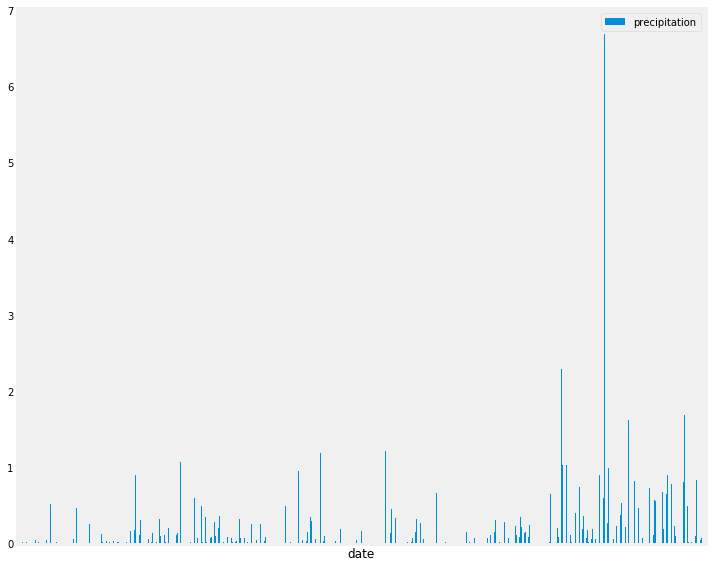

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
prcp_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(10,8)
prcp_df.plot.bar()
plt.tick_params(labelbottom=False)
plt.tight_layout()
plt.grid()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(station_count)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
#active_station = session.query(Station.station).group_by(Station.station).count()
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#x = session.query(func.min(Measurement.prcp), func.max(Measurement.prcp), func.prcp(Measurement.prcp)).\
#    filter(Measurement.station == "USC00519281")

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.tobs).all()

[(54.0, 85.0, 71.66378066378067)]

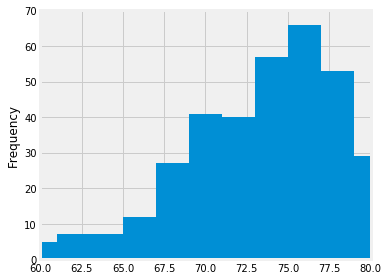

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > query_date).all()

tobs_df = pd.DataFrame(tobs_results, columns=['tobs'])

x = tobs_df["tobs"].tolist()

plt.rcParams['figure.figsize']=(5.5,4)
plt.hist(x,bins=12)
plt.ylabel('Frequency')
plt.axis([60,80,0,70])
plt.tight_layout()
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-01-01', '2017-01-07'))

[(62.0, 68.36585365853658, 74.0)]


    min        avg   max
0  62.0  68.365854  74.0


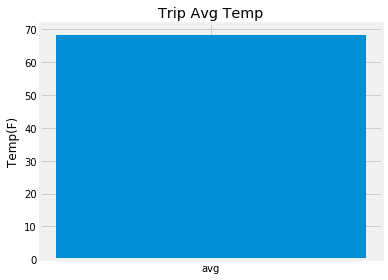

In [40]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temps_results = calc_temps('2017-01-01', '2017-01-07')
temps_df = pd.DataFrame(temps_results, columns=['min', 'avg','max'])
min_df = 62.0
max_df = 74.0
avg_df = 68.36585365853658

yerr = [min_df, max_df]
#temps_df['avg'].plot.bar(rot=0)
plt.bar(x = 'avg', height=avg_df)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
#plt.errorbar(x = 'avg', y=68.36585365853658, yerr=yerr)
print(temps_df)
plt.tight_layout()
plt.show()

In [49]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_rain(start_date, end_date):
    
    return session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

print(calc_rain('2017-01-01', '2017-01-07'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
